This notebook covers the modelling techniques used for getting optimal prediction results.

## Data Cleaning and Preparation

This involves the necessary steps and processing to get both the train and test datasets in an acceptable form for the machine learnning algorithm:

* Creating validation data sets
* Selecting interested logs
* Resolving missing values
* Encoding categorical variables
* Data augmentation

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/TRANSFORM-2021

/content/drive/MyDrive/TRANSFORM-2021


In [3]:
import numpy as np
import random
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

In [4]:
traindata = pd.read_csv('./data/train.csv', sep=';')
testdata = pd.read_csv('./data/leaderboard_test_features.csv.txt', sep=';')

In [5]:
A = np.load('./data/penalty_matrix.npy')   # panlty matrix used for scoring

In [6]:
A

array([[0.   , 2.   , 3.5  , 3.   , 3.75 , 3.5  , 3.5  , 4.   , 4.   ,
        2.5  , 3.875, 3.25 ],
       [2.   , 0.   , 2.375, 2.75 , 4.   , 3.75 , 3.75 , 3.875, 4.   ,
        3.   , 3.75 , 3.   ],
       [3.5  , 2.375, 0.   , 2.   , 3.5  , 3.5  , 3.75 , 4.   , 4.   ,
        2.75 , 3.25 , 3.   ],
       [3.   , 2.75 , 2.   , 0.   , 2.5  , 2.   , 2.25 , 4.   , 4.   ,
        3.375, 3.75 , 3.25 ],
       [3.75 , 4.   , 3.5  , 2.5  , 0.   , 2.625, 2.875, 3.75 , 3.25 ,
        3.   , 4.   , 3.625],
       [3.5  , 3.75 , 3.5  , 2.   , 2.625, 0.   , 1.375, 4.   , 3.75 ,
        3.5  , 4.   , 3.625],
       [3.5  , 3.75 , 3.75 , 2.25 , 2.875, 1.375, 0.   , 4.   , 3.75 ,
        3.125, 4.   , 3.75 ],
       [4.   , 3.875, 4.   , 4.   , 3.75 , 4.   , 4.   , 0.   , 2.75 ,
        3.75 , 3.75 , 4.   ],
       [4.   , 4.   , 4.   , 4.   , 3.25 , 3.75 , 3.75 , 2.75 , 0.   ,
        4.   , 4.   , 3.875],
       [2.5  , 3.   , 2.75 , 3.375, 3.   , 3.5  , 3.125, 3.75 , 4.   ,
        0.   , 2.5  

Scoring matrix for petrophysical interpretation

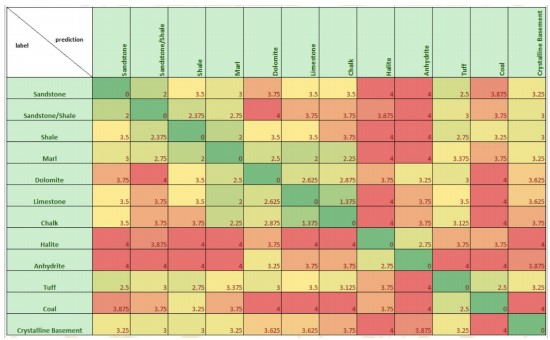

In [7]:
def score(y_true, y_pred):

    '''
    custom metric used for evaluation
    args:
      y_true: actual prediction
      y_pred: predictions made
    '''

    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]

### Creating Validation Sets

Validation sets are created to properly evaluate changes made on the machine learning model. This is important to prevent overfitting the open test data since the blind test is used as the final determiner. So it is important to build ML models that will generalise better on unseen wells. Having no idea how the blind wells would come (geospatial distribution, logs presence), there was no specific guide in selecting train wells, so wells were randomly selected from the train to create two validation sets (each comprising of 10 wells). 

In [8]:
train_wells = traindata.WELL.unique()

In [9]:
print(f'Initial total number of train wells: {len(train_wells)}')

Initial total number of train wells: 98


In [10]:
np.random.seed(40)

In [11]:
valid1 = random.sample(list(train_wells), 10)   #randomly sample 10 well names from train data

QC to remove valid1 wells from train wells to prevent having same well(s) in the second validation data

In [12]:
train_wells = [well for well in train_wells if not well in valid1]
print(f'Number of wells left: {len(train_wells)}')

Number of wells left: 88


In [13]:
valid2 = random.sample(list(train_wells), 10)

train_wells = [well for well in train_wells if not well in valid2]
print(f'Number of wells left: {len(train_wells)}')

Number of wells left: 78


In [14]:
print(len(valid1), len(valid2))

10 10


In [15]:
validation_wells = set(valid1 + valid2)
print(len(validation_wells))

20


Let's proceed to getting the validation data from the train data set and dropping them to prevent any form of data leakage.

In [16]:
def create_validation_set(train, wells):
    
    '''
    Function to validation sets from the full train data using well names
    '''
    
    validation = pd.DataFrame(columns=list(train.columns))
    
    for well in wells:
        welldata = train.loc[train.WELL == well]
        validation = pd.concat((welldata, validation))
        
    return validation

In [17]:
# using function to get data for validation wells

validation1 = create_validation_set(traindata, valid1)
validation2 = create_validation_set(traindata, valid2)

In [18]:
# total validation data

validation = pd.concat((validation1, validation2))

In [19]:
validation.shape, validation1.shape, validation2.shape

((232527, 29), (123486, 29), (109041, 29))

In [20]:
# dropping validation data from train data

new_train = pd.concat([traindata, validation, validation]).drop_duplicates(keep=False)
print(f'Previous train data shape: {traindata.shape}')
print(f'New train data shape: {new_train.shape}')

Previous train data shape: (1170511, 29)
New train data shape: (937984, 29)


In [21]:
# QC to ensure there are no data leakage

previous_rows = traindata.shape[0]
new_train_rows = new_train.shape[0]
validation_rows = validation.shape[0]

print(f'Number of previous train data rows: {previous_rows}')
print(f'Validation + validation rows: {validation_rows+new_train_rows}')

Number of previous train data rows: 1170511
Validation + validation rows: 1170511


In [22]:
# to confirm we still have all samples of the labels in the train data set

new_train.FORCE_2020_LITHOFACIES_LITHOLOGY.value_counts()

65000    573405
30000    136783
65030    120134
70000     45086
80000     26950
99000     11381
70032     10401
88000      8213
90000      3107
74000      1336
86000      1085
93000       103
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, dtype: int64

Now we can proceed to other preparation procedures.

Logs were selected based on user's desire to use them for training. The confidence logs was dropped as this was absent in the test logs as the ML models need the same set of wells used for training in making predictions on the test wells. Other absent logs and logs with low percentage of values from the combined test data are also dropped. This has previously been visualized in the EDA notebook. A cut off of 30% may be selected as criteria for dropping the logs. Let's take a look at that!

In [23]:
print(f'Percentage of values in test logs:')
100 - testdata.isna().sum()/testdata.shape[0]*100

Percentage of values in test logs:


WELL         100.000000
DEPTH_MD     100.000000
X_LOC         99.956867
Y_LOC         99.956867
Z_LOC         99.956867
GROUP        100.000000
FORMATION     94.828418
CALI          95.873116
RSHA          28.582603
RMED          99.570863
RDEP          99.956867
RHOB          87.601070
GR           100.000000
SGR            0.000000
NPHI          76.062609
PEF           82.978521
DTC           99.398330
SP            48.708932
BS            48.955302
ROP           49.943708
DTS           31.596801
DCAL           9.880397
DRHO          81.555130
MUDWEIGHT     14.818037
RMIC           8.272776
ROPA          40.786338
RXO           21.820947
dtype: float64

For better and faster processing, the train, validation and test data sets will be concatenated and processed together as we need these data sets to be in the same formats to get good predictions out of the ML model. But let's have it in mind that the RSHA, SGR, DCAL, MUDWEIGHT, RMIC and RXO will be dropped from the wells. Let's proceed.

Let's extract the data sets indices that will be used for splitting the features and targets into their respective datasets after prepration is complete. We will also be extracting the train target

In [24]:
ntrain = new_train.shape[0]
ntest = testdata.shape[0]
nvalid1 = validation1.shape[0]
nvalid2 = validation2.shape[0]
nvalid3 = validation.shape[0]

df = pd.concat((new_train, testdata, validation1, validation2, validation)).reset_index(drop=True)

So the combined dataframe for preparation

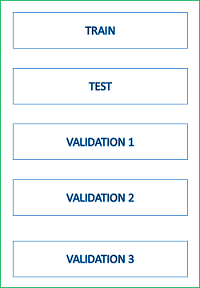

In [25]:
df.shape

(1539824, 29)

The procedure below is used to extract data needed for the augmentation procedure to be performed after every other preparation has been done

In [26]:
#making a copy of the dataframes

train = new_train.copy()
test = testdata.copy()
valid1 = validation1.copy()
valid2 = validation2.copy()
valid = validation.copy()

In [27]:
# extracting the data sets well names and depth values needed for augmentation

train_well = train.WELL.values
train_depth = train.DEPTH_MD.values

test_well = test.WELL.values
test_depth = test.DEPTH_MD.values
 
valid1_well = valid1.WELL.values
valid1_depth = valid1.DEPTH_MD.values
 
valid2_well = valid2.WELL.values
valid2_depth = valid2.DEPTH_MD.values
 
valid_well = valid.WELL.values
valid_depth = valid.DEPTH_MD.values

Now let's extract the data sets labels and prepare them for training and validation performance check.

In [28]:
lithology = train['FORCE_2020_LITHOFACIES_LITHOLOGY']
valid1_lithology = valid1['FORCE_2020_LITHOFACIES_LITHOLOGY']
valid2_lithology = valid2['FORCE_2020_LITHOFACIES_LITHOLOGY']
valid_lithology = valid['FORCE_2020_LITHOFACIES_LITHOLOGY']
 
lithology_numbers = {30000: 0,
                 65030: 1,
                 65000: 2,
                 80000: 3,
                 74000: 4,
                 70000: 5,
                 70032: 6,
                 88000: 7,
                 86000: 8,
                 99000: 9,
                 90000: 10,
                 93000: 11}
 
lithology = lithology.map(lithology_numbers)
valid1_lithology = valid1_lithology.map(lithology_numbers)
valid2_lithology = valid2_lithology.map(lithology_numbers)
valid_lithology = valid_lithology.map(lithology_numbers)

In [29]:
print(f'dataframe shapes before dropping columns: {df.shape}')

def drop_columns(data, *args):

    '''
    function used to drop columns.
    args:: 
      data:  dataframe to be operated on
      *args: a list of columns to be dropped from the dataframe

    return: returns a dataframe with the columns dropped
    '''
    
    columns = []
    for _ in args:
        columns.append(_)
        
    data = data.drop(columns, axis=1)
        
    return data

columns_dropped = ['RSHA', 'SGR', 'DCAL', 'MUDWEIGHT', 'RMIC', 'RXO'] #columns to be dropped
df = drop_columns(df, *columns_dropped)
print(f'shape of dataframe after dropping columns {df.shape}')

dataframe shapes before dropping columns: (1539824, 29)
shape of dataframe after dropping columns (1539824, 23)


### Data Encoding

The categorical logs/columns in the data set need to be encoded for use by the ML algorithm. From the data visualization, we saw the high dimensionality of the logs (especially the FORMATION log with 69 distinct values), so label encoding will be applied instead of one hot encoding these features to prevent high dimensionality of the data.

In [30]:
df['GROUP_encoded'] = df['GROUP'].astype('category')
df['GROUP_encoded'] = df['GROUP_encoded'].cat.codes 

df['FORMATION_encoded'] = df['FORMATION'].astype('category')
df['FORMATION_encoded'] = df['FORMATION_encoded'].cat.codes

df['WELL_encoded'] = df['WELL'].astype('category')
df['WELL_encoded'] = df['WELL_encoded'].cat.codes

print(f'shape of dataframe after label encoding columns {df.shape}')

shape of dataframe after label encoding columns (1539824, 26)


In [31]:
# dropping the previous columns after encoding

df = df.drop(['WELL', 'GROUP', 'FORMATION'], axis=1)

### Filling Missing Values

Some fractions of missing values still exist in present logs, how do we resolve that? While we can use a mean of values in a window to solve this, backward or forward fill, we could also decide to fill up all missing values with a distinct value different from other values. This way, the ML algorithm used (in this case a gradient tree algorithm) can differentiate this better. From validation, this improved result better. -9999 is used, and since this is a classification problem as opposed to a regression where we predict actual lithology values, outlier effect is not observed in the output.

In [32]:
df = df.fillna(-9999)

In [33]:
df.isna().sum()/df.shape[0]*100

DEPTH_MD                             0.0
X_LOC                                0.0
Y_LOC                                0.0
Z_LOC                                0.0
CALI                                 0.0
RMED                                 0.0
RDEP                                 0.0
RHOB                                 0.0
GR                                   0.0
NPHI                                 0.0
PEF                                  0.0
DTC                                  0.0
SP                                   0.0
BS                                   0.0
ROP                                  0.0
DTS                                  0.0
DRHO                                 0.0
ROPA                                 0.0
FORCE_2020_LITHOFACIES_LITHOLOGY     0.0
FORCE_2020_LITHOFACIES_CONFIDENCE    0.0
GROUP_encoded                        0.0
FORMATION_encoded                    0.0
WELL_encoded                         0.0
dtype: float64

Now that we've completed the majority of the preparation, let's split back our concatenated dataframe into their validation sets, train and test set

In [34]:
data = df.copy()   #making a copy of the preparaed dataframe to work with
data.shape

(1539824, 23)

Remember the shape of the concatenated dataframe;

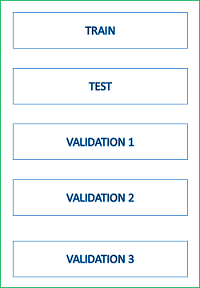

using the data sets indices will be used for slicing out their corresponding features

In [35]:
train = data[:ntrain].copy()
train.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
        
test = data[ntrain:(ntest+ntrain)].copy()
test.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
test = test.reset_index(drop=True)

valid1 = data[(ntest+ntrain):(ntest+ntrain+nvalid1)].copy()
valid1.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
valid1 = valid1.reset_index(drop=True)

valid2 = data[(ntest+ntrain+nvalid1):(ntest+ntrain+nvalid1+nvalid2)].copy()
valid2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
valid2 = valid2.reset_index(drop=True)

valid = data[(ntest+ntrain+nvalid1+nvalid2):].copy()
valid.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
valid = valid.reset_index(drop=True)

In [36]:
# checking shapes of sliced data sets for QC

train.shape, test.shape, valid1.shape, valid2.shape, valid.shape

((937984, 22), (136786, 22), (123486, 22), (109041, 22), (232527, 22))

### Data Augmentation

The data augmentation technique is extracted from the ISPL team code for the 2016 SEG ML competition : https://github.com/seg/2016-ml-contest/tree/master/ispl . The technique was based on the assumption that "facies do not abrutly change from a given depth layer to the next one". This was implemented by aggregating features at neighbouring depths and computing the feature spatial gradient.

In [37]:
# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]
 
    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))
 
    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row
 
    return X_aug
 
# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad
 
# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    return X_aug

In [38]:
print(f'Shape of datasets before augmentation {train.shape, test.shape, valid1.shape, valid2.shape, valid.shape}')

aug_train = augment_features(train.values, train_well, train_depth)
aug_test = augment_features(test.values, test_well, test_depth)
aug_valid1 = augment_features(valid1.values, valid1_well, valid1_depth)
aug_valid2 = augment_features(valid2.values, valid2_well, valid2_depth)
aug_valid = augment_features(valid.values, valid_well, valid_depth)

print(f'Shape of datasets after augmentation {aug_train.shape, aug_test.shape, aug_valid1.shape, aug_valid2.shape, aug_valid.shape}')

Shape of datasets before augmentation ((937984, 22), (136786, 22), (123486, 22), (109041, 22), (232527, 22))
Shape of datasets after augmentation ((937984, 88), (136786, 88), (123486, 88), (109041, 88), (232527, 88))


In [39]:
pd.DataFrame(aug_train).head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87
0,0.000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,494.528,437641.96875,6470972.5,-469.501831,19.480835,1.611410,1.798681,1.884186,80.200851,-9999.0,20.915468,161.131180,24.612379,-9999.0,34.636410,-9999.0,-0.574928,-9999.0,...,19.468800,1.618070,1.795641,1.889794,79.262886,-9999.0,19.383013,160.603470,23.895531,-9999.0,34.636410,-9999.0,-0.570188,-9999.0,1.0,6.0,-1.0,0.0,1.0,0.0,0.0,-0.999852,-0.079180,0.043819,-0.020000,0.036893,-6.170825,0.0,-10.081944,-3.471776,-4.716108,0.0,0.000000,0.0,0.031179,0.0,0.0,0.0,0.0,0.0
1,494.528,437641.96875,6470972.5,-469.501831,19.480835,1.611410,1.798681,1.884186,80.200851,-9999.0,20.915468,161.131180,24.612379,-9999.0,34.636410,-9999.0,-0.574928,-9999.0,1.0,6.0,-1.0,0.0,494.680,437641.96875,6470972.5,-469.653809,19.468800,1.618070,1.795641,1.889794,79.262886,-9999.0,19.383013,160.603470,23.895531,-9999.0,34.636410,-9999.0,-0.570188,-9999.0,...,19.468800,1.626459,1.800733,1.896523,74.821999,-9999.0,22.591518,160.173615,23.916357,-9999.0,34.779556,-9999.0,-0.574245,-9999.0,1.0,6.0,-1.0,0.0,1.0,0.0,0.0,-0.999852,0.000000,0.055186,0.033500,0.044271,-29.216365,0.0,21.108590,-2.827996,0.137015,0.0,0.941753,0.0,-0.026689,0.0,0.0,0.0,0.0,0.0
2,494.680,437641.96875,6470972.5,-469.653809,19.468800,1.618070,1.795641,1.889794,79.262886,-9999.0,19.383013,160.603470,23.895531,-9999.0,34.636410,-9999.0,-0.570188,-9999.0,1.0,6.0,-1.0,0.0,494.832,437641.96875,6470972.5,-469.805786,19.468800,1.626459,1.800733,1.896523,74.821999,-9999.0,22.591518,160.173615,23.916357,-9999.0,34.779556,-9999.0,-0.574245,-9999.0,...,19.459282,1.621594,1.801517,1.891913,72.878922,-9999.0,32.191910,160.149429,23.793688,-9999.0,39.965164,-9999.0,-0.586315,-9999.0,1.0,6.0,-1.0,0.0,1.0,0.0,0.0,-1.000053,-0.062616,-0.032003,0.005153,-0.030329,-12.783402,0.0,63.160470,-0.159113,-0.807034,0.0,34.115842,0.0,-0.079409,0.0,0.0,0.0,0.0,0.0
3,494.832,437641.96875,6470972.5,-469.805786,19.468800,1.626459,1.800733,1.896523,74.821999,-9999.0,22.591518,160.173615,23.916357,-9999.0,34.779556,-9999.0,-0.574245,-9999.0,1.0,6.0,-1.0,0.0,494.984,437641.96875,6470972.5,-469.957794,19.459282,1.621594,1.801517,1.891913,72.878922,-9999.0,32.191910,160.149429,23.793688,-9999.0,39.965164,-9999.0,-0.586315,-9999.0,...,19.453100,1.602679,1.795299,1.880034,71.729141,-9999.0,38.495632,160.128342,24.104078,-9999.0,57.483765,-9999.0,-0.597914,-9999.0,1.0,6.0,-1.0,0.0,1.0,0.0,0.0,-0.999852,-0.040669,-0.124441,-0.040905,-0.078150,-7.564344,0.0,41.471858,-0.138735,2.042043,0.0,115.253950,0.0,-0.076305,0.0,0.0,0.0,0.0,0.0
4,494.984,437641.96875,6470972.5,-469.957794,19.459282,1.621594,1.801517,1.891913,72.878922,-9999.0,32.191910,160.149429,23.793688,-9999.0,39.965164,-9999.0,-0.586315,-9999.0,1.0,6.0,-1.0,0.0,495.136,437641.96875,6470972.5,-470.109772,19.453100,1.602679,1.795299,1.880034,71.729141,-9999.0,38.495632,160.128342,24.104078,-9999.0,57.483765,-9999.0,-0.597914,-9999.0,...,19.453100,1.585567,1.804719,1.879687,72.014420,-9999.0,43.657482,160.149292,23.931278,-9999.0,75.281410,-9999.0,-0.601600,-9999.0,1.0,6.0,-1.0,0.0,1.0,0.0,0.0,-1.000053,0.000000,-0.112580,0.061971,-0.002281,1.876831,0.0,33.959539,0.137831,-1.136843,0.0,117.089773,0.0,-0.024252,0.0,0.0,0.0,0.0,0.0
5,495.136,437641.96875,6470972.5,-470.109772,19.453100,1.602679,1.795299,1.880034,71.729141,-9999.0,38.495632,160.128342,24.104078,-9999.0,57.483765,-9999.0,-0.597914,-9999.0,1.0,6.0,-1.0,0.0,495.288,437641.96875,6470972.5,-470.261780,19.453100,1.585567,1.804719,1.879687,72.014420,-9999.0,43.657482,160.149292,23.931278,-9999.0,75.281410,-9999.0,-0.601600,-9999.0,...,19.462496,1.576569,1.805498,1.878731,72.588089,-9999.0,42.236221,161.250381,23.381790,-9999.0,76.1

In [40]:
train.head(10)

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RMED,RDEP,RHOB,GR,NPHI,PEF,DTC,SP,BS,ROP,DTS,DRHO,ROPA,FORCE_2020_LITHOFACIES_CONFIDENCE,GROUP_encoded,FORMATION_encoded,WELL_encoded
0,494.528,437641.96875,6470972.5,-469.501831,19.480835,1.611410,1.798681,1.884186,80.200851,-9999.0,20.915468,161.131180,24.612379,-9999.0,34.636410,-9999.0,-0.574928,-9999.0,1.0,6,-1,0
1,494.680,437641.96875,6470972.5,-469.653809,19.468800,1.618070,1.795641,1.889794,79.262886,-9999.0,19.383013,160.603470,23.895531,-9999.0,34.636410,-9999.0,-0.570188,-9999.0,1.0,6,-1,0
2,494.832,437641.96875,6470972.5,-469.805786,19.468800,1.626459,1.800733,1.896523,74.821999,-9999.0,22.591518,160.173615,23.916357,-9999.0,34.779556,-9999.0,-0.574245,-9999.0,1.0,6,-1,0
3,494.984,437641.96875,6470972.5,-469.957794,19.459282,1.621594,1.801517,1.891913,72.878922,-9999.0,32.191910,160.149429,23.793688,-9999.0,39.965164,-9999.0,-0.586315,-9999.0,1.0,6,-1,0
4,495.136,437641.96875,6470972.5,-470.109772,19.453100,1.602679,1.795299,1.880034,71.729141,-9999.0,38.495632,160.128342,24.104078,-9999.0,57.483765,-9999.0,-0.597914,-9999.0,1.0,6,-1,0
5,495.288,437641.96875,6470972.5,-470.261780,19.453100,1.585567,1.804719,1.879687,72.014420,-9999.0,43.657482,160.149292,23.931278,-9999.0,75.281410,-9999.0,-0.601600,-9999.0,1.0,6,-1,0
6,495.440,437641.96875,6470972.5,-470.413788,19.462496,1.576569,1.805498,1.878731,72.588089,-9999.0,42.236221,161.250381,23.381790,-9999.0,76.199951,-9999.0,-0.598369,-9999.0,1.0,6,-1,0
7,495.592,437641.96875,6470972.5,-470.565796,19.468800,1.587011,1.808367,1.867837,71.283051,-9999.0,39.933563,162.214416,23.632166,-9999.0,76.199951,-9999.0,-0.602039,-9999.0,1.0,6,-1,0
8,495.744,437641.96875,6470972.5,-470.717773,19.468800,1.613674,1.815813,1.847233,69.721436,-9999.0,39.163223,161.575104,22.163542,-9999.0,75.898796,-9999.0,-0.614364,-9999.0,1.0,6,-1,0
9,495.896,437641.96875,6470972.5,-470.869782,19.468800,1.634622,1.813916,1.836309,66.677727,-9999.0,37.802933,160.583359,23.659925,-9999.0,68.121262,-9999.0,-0.621813,-9999.0,1.0,6,-1,0


### Model Training

The choice of algorithm for this tutorial workflow is xgboost. Why? Performance on previously done validation was better, and also at a faster compute speed than catboost. Random forest is also a great algorithm to try. Let's implement our xgboost tree. This will be done in a 10 fold cross validation technique. This is done to get a better performance and a confident result that is not due to randomness. We will be using StratifiedKFold function from sklearn. Let's look at that.

In [41]:
def show_evaluation(pred, true):

  '''

  function to show model performance and evaluation
  args:
    pred: predicted value(a list)
    true: actual values (a list)

  prints the custom metric performance, accuracy and F1 score of predictions

  '''

  print(f'Default score: {score(true.values, pred)}')
  print(f'Accuracy is: {accuracy_score(true, pred)}')
  print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')

In [42]:
split = 10

kf = StratifiedKFold(n_splits=split, shuffle=True)

In [43]:
# initializing the xgboost model

model = xgb.XGBClassifier(n_estimators=100, max_depth=10, booster='gbtree',
                          objective='softprob', learning_rate=0.1, random_state=0,
                          subsample=0.9, colsample_bytree=0.9, tree_method='gpu_hist',
                          eval_metric='mlogloss', reg_lambda=1500)

In [44]:
# initializing the prediction probabilities arrays

test_pred = np.zeros((len(test), 12))
valid1_pred = np.zeros((len(valid1), 12))
valid2_pred = np.zeros((len(valid2), 12))
valid_pred = np.zeros((len(valid), 12))

In [46]:
#implementing the CV Loop

i = 1
for (train_index, test_index) in kf.split(train, lithology):
    X_train,X_test = train.iloc[train_index], train.iloc[test_index]
    Y_train,Y_test = lithology.iloc[train_index], lithology.iloc[test_index]
    
        
    model.fit(X_train, Y_train, early_stopping_rounds=100, eval_set=[(X_test, Y_test)], verbose=20)
    
    prediction1 = model.predict(valid1)
    prediction2 = model.predict(valid2)
    prediction = model.predict(valid)
    
    print(show_evaluation(prediction1, valid1_lithology))
    print(show_evaluation(prediction2, valid2_lithology))
    print(show_evaluation(prediction, valid_lithology))
 
    print(f'----------------------- FOLD {i} ---------------------')
    i+=1
    
    valid1_pred += model.predict_proba(valid1)
    valid2_pred += model.predict_proba(valid2)
    valid_pred += model.predict_proba(valid)

[0]	validation_0-mlogloss:2.17457
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[20]	validation_0-mlogloss:0.710782
[40]	validation_0-mlogloss:0.467518
[60]	validation_0-mlogloss:0.385437
[80]	validation_0-mlogloss:0.343511
[99]	validation_0-mlogloss:0.31839
Default score: -0.5653586236496445
Accuracy is: 0.7857408937045495
F1 is: 0.8122836993319609
None
Default score: -0.6625329004686311
Accuracy is: 0.7506992782531341
F1 is: 0.7534207644689714
None
Default score: -0.6109274406843076
Accuracy is: 0.7693085104095438
F1 is: 0.7844794455633661
None
----------------------- FOLD 1 ---------------------
[0]	validation_0-mlogloss:2.17483
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[20]	validation_0-mlogloss:0.712045
[40]	validation_0-mlogloss:0.468513
[60]	validation_0-mlogloss:0.387018
[80]	validation_0-mlogloss:0.346026
[99]	validation_0-mlogloss:0.320446
Default score: -0.595705181154139
Accuracy is: 0.7748084803135578
F1 is: 0.80599247450

In [47]:
# finding the probabilities average and converting the numpy array to a dataframe

valid1_pred = pd.DataFrame(valid1_pred/split)
valid2_pred = pd.DataFrame(valid2_pred/split)
valid_pred = pd.DataFrame(valid_pred/split)

In [48]:
# extracting the index position with the highest probability as the lithology classp

valid1_pred = valid1_pred.idxmax(axis=1)
valid2_pred = valid2_pred.idxmax(axis=1)
valid_pred = valid_pred.idxmax(axis=1)

Evaluating the final predictions from the CV and max probability indexing

In [49]:
show_evaluation(valid1_pred, valid1_lithology)

Default score: -0.5692335568404515
Accuracy is: 0.7848420063812902
F1 is: 0.8117557911089638


In [50]:
show_evaluation(valid2_pred, valid2_lithology)

Default score: -0.6653632578571363
Accuracy is: 0.7493786740767234
F1 is: 0.7516536044917477


In [51]:
show_evaluation(valid_pred, valid_lithology)

Default score: -0.6143125314479608
Accuracy is: 0.7682118635685318
F1 is: 0.7834132027585581


### Thanks for listening...